# Predição da Evapotranspiração

## Importação das bibliotecas utilizadas

In [1]:
# Importando os módulos
import csv
import pandas as pd
import matplotlib.pyplot as plt    
import numpy as np  
from sklearn.linear_model import LinearRegression
import h2o
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from datetime import datetime, date, time, timezone
import matplotlib.pyplot as plt
%matplotlib inline 

## Importação dos dados

In [2]:
df_data = pd.read_csv('../dados/dataset.csv')
df_data.head()

,TIMESTAMP,RECORD,BP_mbar_Max,BP_mbar_Min,Rain_mm_Tot,AirTC_Max,AirTC_Min,RH_Max,RH_Min,SlrkJ_Tot,TdC_Max,TdC_Min,AirTC_Avg,RH_Avg,WS_ms_Avg,SlrkJ_Avg,Eto
0,2015-02-24 22:00:00,13253,600.8486,600.3632,0.000,23.472,23.341,99.998,99.998,0.193834,23.472,23.341,23.39763,99.99786,0.000000,0.000538,0.0002984148
1,2015-02-24 23:00:00,13254,600.7875,600.4396,0.000,23.472,23.26,99.998,99.998,0.137363,23.472,23.260,23.3635,99.99786,0.000000,0.000382,0.0002987745
2,2015-02-25 00:00:00,13255,601.1295,600.7021,0.254,23.371,23.212,99.998,99.998,0.137363,23.371,23.212,23.29213,99.99786,0.002500,0.000382,0.0002994588
3,2015-02-25 01:00:00,13256,601.1752,600.4365,0.000,23.402,23.292,99.998,99.998,0.202992,23.402,23.292,23.34686,99.99786,0.023333,0.000564,0.0002972446
4,2015-02-25 02:00:00,13257,601.1813,600.6227,0.000,23.35,23.212,99.998,99.998,0.203755,23.350,23.212,23.2819,99.99786,0.000000,0.000566,0.0002998548


In [3]:
df_data['TIMESTAMP'] =  pd.to_datetime(df_data['TIMESTAMP'], format='%Y-%m-%d %H:%M:%S')

Na presente análise, vamos replicar os resultados obtidos em [CAMINHA, Hinessa Dantas], utilizando o mesmo dataset. 

Para considerar o dataset completo, elimine a próxima célula.

In [4]:
data_inicial = datetime.strptime("2016-6-16 00:00:00", "%Y-%m-%d %H:%M:%S")
data_final = datetime.strptime("2016-10-19 23:59:59", "%Y-%m-%d %H:%M:%S")

df_data = df_data[df_data['TIMESTAMP'] > data_inicial]
df_data = df_data.reset_index(drop=True)

In [5]:
df_data['AirTC_Max'] = df_data['AirTC_Max'].astype(np.float64)
df_data['AirTC_Min'] = df_data['AirTC_Min'].astype(np.float64)
df_data['AirTC_Avg'] = df_data['AirTC_Avg'].astype(np.float64)
df_data['Eto'] = df_data['Eto'].astype(np.float64)

df_data.dtypes

TIMESTAMP      datetime64[ns]
RECORD                  int64
BP_mbar_Max           float64
BP_mbar_Min           float64
Rain_mm_Tot           float64
AirTC_Max             float64
AirTC_Min             float64
RH_Max                float64
RH_Min                float64
SlrkJ_Tot             float64
TdC_Max               float64
TdC_Min               float64
AirTC_Avg             float64
RH_Avg                float64
WS_ms_Avg             float64
SlrkJ_Avg             float64
Eto                   float64
dtype: object

In [6]:
df_data = df_data.set_index('TIMESTAMP')

## Limpeza dos dados

In [7]:
df_filtered_data = df_data

### Precipitação

Para essa feature, vamos remover todos os valores (```Rain_mm_Tot```) maiores do que 1.

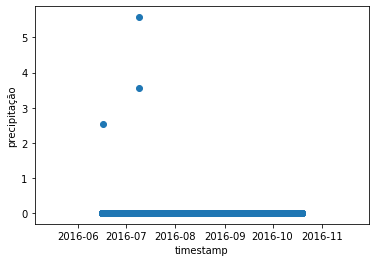

In [8]:
plt.scatter(df_filtered_data.index, df_filtered_data['Rain_mm_Tot'])
plt.xlabel('timestamp')
plt.ylabel('precipitação')
plt.show()

In [9]:
df_filtered_data = df_filtered_data[df_filtered_data['Rain_mm_Tot'] <= 1]
df_filtered_data.shape

(3008, 16)

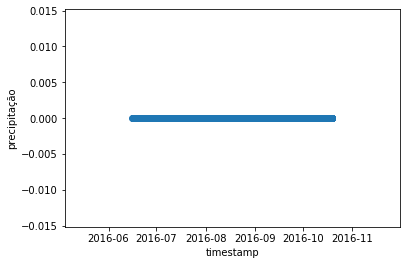

In [10]:
plt.scatter(df_filtered_data.index, df_filtered_data['Rain_mm_Tot'])
plt.xlabel('timestamp')
plt.ylabel('precipitação')
plt.show()

### Velocidade do vento

Para essa feature, vamos remover todos os valores (```WS_ms_Avg```) maiores do que 4.

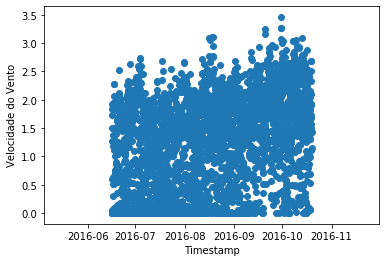

In [11]:
plt.scatter(df_filtered_data.index, df_filtered_data['WS_ms_Avg'])
plt.xlabel('Timestamp')
plt.ylabel('Velocidade do Vento')
plt.show()

In [12]:
df_filtered_data = df_filtered_data[df_filtered_data['WS_ms_Avg'] <=4]
df_filtered_data.shape

(3008, 16)

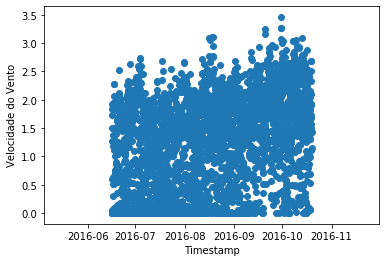

In [13]:
plt.scatter(df_filtered_data.index, df_filtered_data['WS_ms_Avg'])
plt.xlabel('Timestamp')
plt.ylabel('Velocidade do Vento')
plt.show()

### Pressão atmosférica máxima

Para essa feature, vamos remover todos os valores (```BP_mbar_Max```) maiores do que 625.

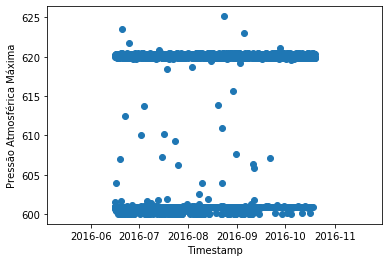

In [14]:
plt.scatter(df_filtered_data.index, df_filtered_data['BP_mbar_Max'])
plt.xlabel('Timestamp')
plt.ylabel('Pressão Atmosférica Máxima')
plt.show()

In [15]:
df_filtered_data = df_filtered_data[df_filtered_data['BP_mbar_Max'] <= 625]
df_filtered_data.shape

(3007, 16)

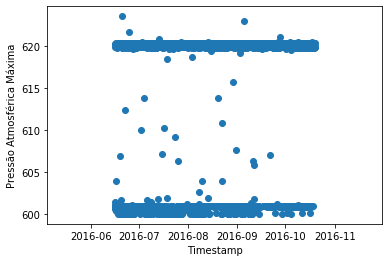

In [16]:
plt.scatter(df_filtered_data.index, df_filtered_data['BP_mbar_Max'])
plt.xlabel('Timestamp')
plt.ylabel('Pressão Atmosférica Máxima')
plt.show()

### Radiação Solar Média

Para essa feature, vamos remover todos os valores (```SlrkJ_Avg```) maiores do que 25.4809.

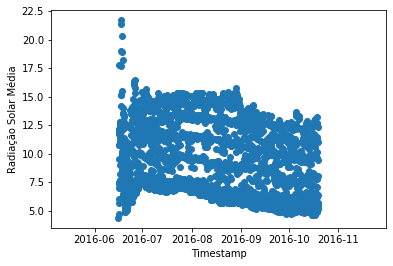

In [17]:
plt.scatter(df_filtered_data.index, df_filtered_data['SlrkJ_Avg'])
plt.xlabel('Timestamp')
plt.ylabel('Radiação Solar Média')
plt.show()

In [18]:
df_filtered_data = df_filtered_data[df_filtered_data['SlrkJ_Avg'] <= 25.4809]
df_filtered_data.shape

(3007, 16)

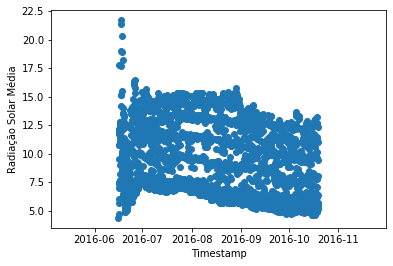

In [19]:
plt.scatter(df_filtered_data.index, df_filtered_data['SlrkJ_Avg'])
plt.xlabel('Timestamp')
plt.ylabel('Radiação Solar Média')
plt.show()

## Radiação Solar Total
Para essa feature, vamos remover todos os valores (```SlrkJ_Tot```) maiores do que 600.0000.

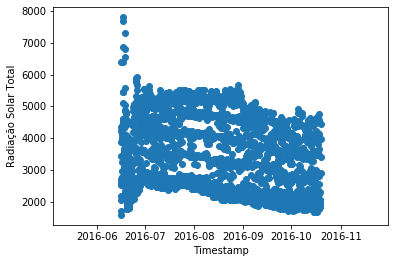

In [20]:
plt.scatter(df_filtered_data.index, df_filtered_data['SlrkJ_Tot'])
plt.xlabel('Timestamp')
plt.ylabel('Radiação Solar Total')
plt.show()

In [21]:
df_filtered_data = df_filtered_data[df_filtered_data['SlrkJ_Tot'] <= 6000000]
df_filtered_data.shape

(3007, 16)

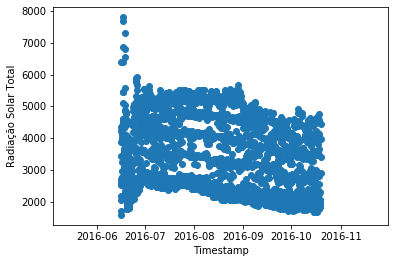

In [22]:
plt.scatter(df_filtered_data.index, df_filtered_data['SlrkJ_Tot'])
plt.xlabel('Timestamp')
plt.ylabel('Radiação Solar Total')
plt.show()

## Temperatura Mínima¶
Para essa feature, vamos remover todos os valores (```TdC_Min```) maiores do que 23.4105.

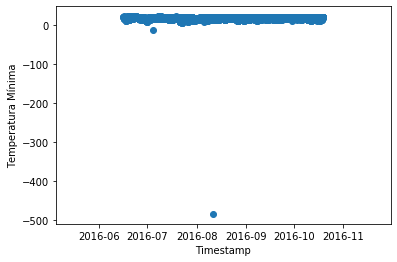

In [23]:
plt.scatter(df_filtered_data.index, df_filtered_data['TdC_Min'])
plt.xlabel('Timestamp')
plt.ylabel('Temperatura Mínima')
plt.show()

In [24]:
df_filtered_data = df_filtered_data[df_filtered_data['TdC_Min'] <= 23.4105]
df_filtered_data.shape

(3007, 16)

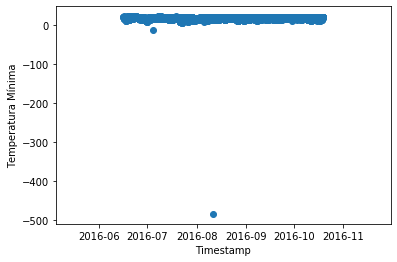

In [25]:
plt.scatter(df_filtered_data.index, df_filtered_data['TdC_Min'])
plt.xlabel('Timestamp')
plt.ylabel('Temperatura Mínima')
plt.show()

## Umidade relativa do ar média
Para essa feature, vamos remover todos os valores (```RH_Avg```) maiores do que 99.8006.

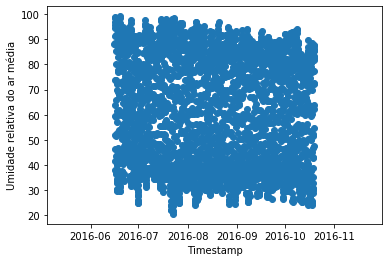

In [26]:
plt.scatter(df_filtered_data.index, df_filtered_data['RH_Avg'])
plt.xlabel('Timestamp')
plt.ylabel('Umidade relativa do ar média')
plt.show()

In [27]:
df_filtered_data = df_filtered_data[df_filtered_data['RH_Avg'] <= 99.8006]
df_filtered_data.shape

(3007, 16)

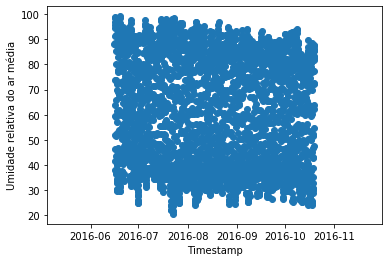

In [28]:
plt.scatter(df_filtered_data.index, df_filtered_data['RH_Avg'])
plt.xlabel('Timestamp')
plt.ylabel('Umidade relativa do ar média')
plt.show()

## Temperatura Máxima¶
Para essa feature, vamos remover todos os valores (```TdC_Max```) maiores do que 24.8820.

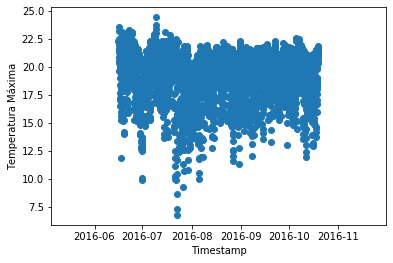

In [29]:
plt.scatter(df_filtered_data.index, df_filtered_data['TdC_Max'])
plt.xlabel('Timestamp')
plt.ylabel('Temperatura Máxima')
plt.show()

In [30]:
df_filtered_data = df_filtered_data[df_filtered_data['TdC_Max'] <= 24.8820]
df_filtered_data.shape

(3007, 16)

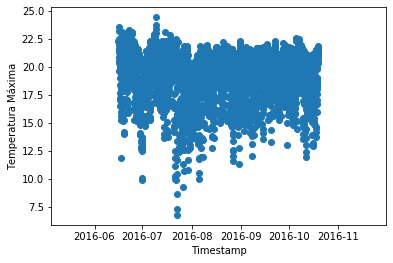

In [31]:
plt.scatter(df_filtered_data.index, df_filtered_data['TdC_Max'])
plt.xlabel('Timestamp')
plt.ylabel('Temperatura Máxima')
plt.show()

## Temperatura do ar mínima
Para essa feature, vamos remover todos os valores (```AirTC_Min```) menores do que 1.

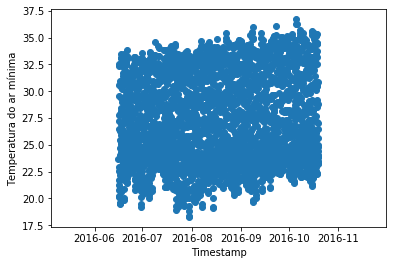

In [32]:
plt.scatter(df_filtered_data.index, df_filtered_data['AirTC_Min'])
plt.xlabel('Timestamp')
plt.ylabel('Temperatura do ar mínima')
plt.show()

In [33]:
df_filtered_data = df_filtered_data[df_filtered_data['AirTC_Min'] >= 1]
df_filtered_data.shape

(3007, 16)

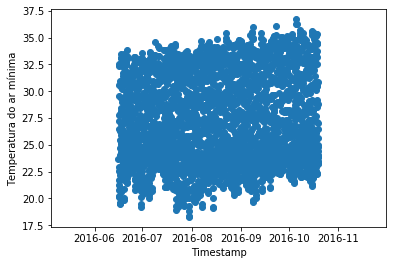

In [34]:
plt.scatter(df_filtered_data.index, df_filtered_data['AirTC_Min'])
plt.xlabel('Timestamp')
plt.ylabel('Temperatura do ar mínima')
plt.show()

## Temperatura do ar mínima¶
Para essa feature, vamos remover todos os valores (```AirTC_Min```) maiores do que 36.692.

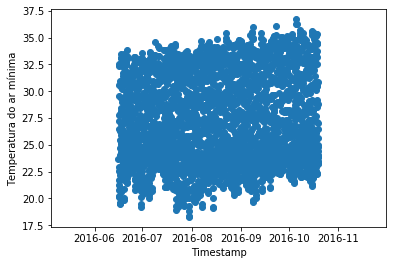

In [35]:
plt.scatter(df_filtered_data.index, df_filtered_data['AirTC_Min'])
plt.xlabel('Timestamp')
plt.ylabel('Temperatura do ar mínima')
plt.show()

In [36]:
df_filtered_data = df_filtered_data[df_filtered_data['AirTC_Min'] <= 36.692]
df_filtered_data.shape

(3007, 16)

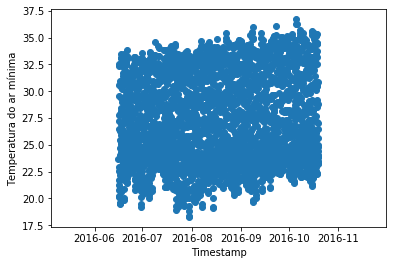

In [37]:
plt.scatter(df_filtered_data.index, df_filtered_data['AirTC_Min'])
plt.xlabel('Timestamp')
plt.ylabel('Temperatura do ar mínima')
plt.show()

## Temperatura do ar máxima
Para essa feature, vamos remover todos os valores (```AirTC_Max```) menores do que 1.

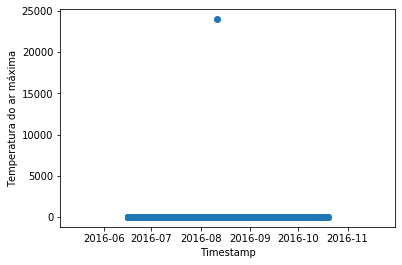

In [38]:
plt.scatter(df_filtered_data.index, df_filtered_data['AirTC_Max'])
plt.xlabel('Timestamp')
plt.ylabel('Temperatura do ar máxima')
plt.show()

In [39]:
df_filtered_data = df_filtered_data[df_filtered_data['AirTC_Max'] >= 1]
df_filtered_data.shape

(3007, 16)

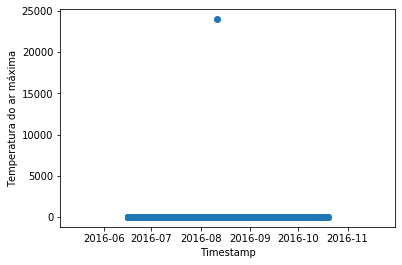

In [40]:
plt.scatter(df_filtered_data.index, df_filtered_data['AirTC_Max'])
plt.xlabel('Timestamp')
plt.ylabel('Temperatura do ar máxima')
plt.show()

## Temperatura do ar máxima
Para essa feature, vamos remover todos os valores (```AirTC_Max```) maiores do que 37.965.

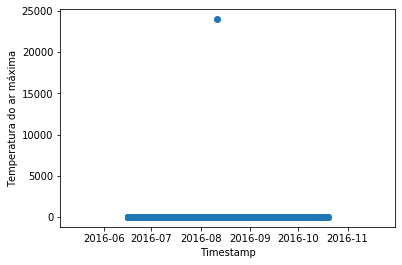

In [41]:
plt.scatter(df_filtered_data.index, df_filtered_data['AirTC_Max'])
plt.xlabel('Timestamp')
plt.ylabel('Temperatura do ar máxima')
plt.show()

In [42]:
df_filtered_data = df_filtered_data[df_filtered_data['AirTC_Max'] <= 37.965]
df_filtered_data.shape

(3006, 16)

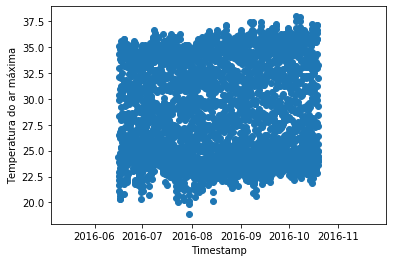

In [43]:
plt.scatter(df_filtered_data.index, df_filtered_data['AirTC_Max'])
plt.xlabel('Timestamp')
plt.ylabel('Temperatura do ar máxima')
plt.show()

## Umidade relativa do ar mínima
Para essa feature, vamos remover todos os valores (```RH_Min```) maiores do que 87.062.

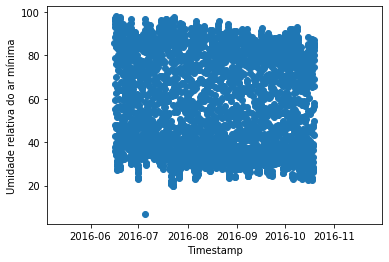

In [44]:
plt.scatter(df_filtered_data.index, df_filtered_data['RH_Min'])
plt.xlabel('Timestamp')
plt.ylabel('Umidade relativa do ar mínima')
plt.show()

In [45]:
df_filtered_data = df_filtered_data[df_filtered_data['RH_Min'] <= 87.062]
df_filtered_data.shape

(2692, 16)

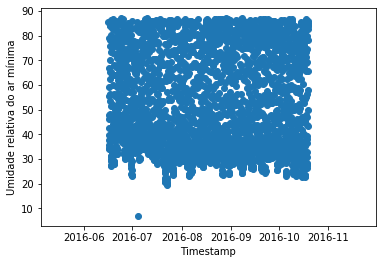

In [46]:
plt.scatter(df_filtered_data.index, df_filtered_data['RH_Min'])
plt.xlabel('Timestamp')
plt.ylabel('Umidade relativa do ar mínima')
plt.show()

## Umidade relativa do ar máxima
Para essa feature, vamos remover todos os valores (```RH_Max```) maiores do que 95.5.

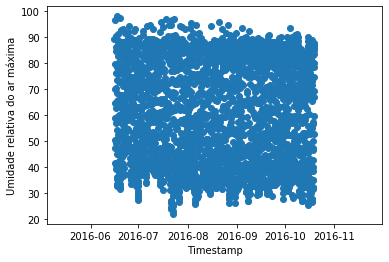

In [47]:
plt.scatter(df_filtered_data.index, df_filtered_data['RH_Max'])
plt.xlabel('Timestamp')
plt.ylabel('Umidade relativa do ar máxima')
plt.show()

In [48]:
df_filtered_data = df_filtered_data[df_filtered_data['RH_Max'] <= 95.5]
df_filtered_data.shape

(2684, 16)

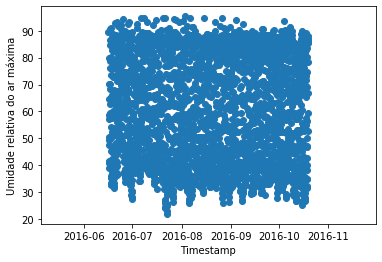

In [49]:
plt.scatter(df_filtered_data.index, df_filtered_data['RH_Max'])
plt.xlabel('Timestamp')
plt.ylabel('Umidade relativa do ar máxima')
plt.show()

In [50]:
df_filtered_data = df_filtered_data.reset_index(drop=True)

In [51]:
df_filtered_data

,RECORD,BP_mbar_Max,BP_mbar_Min,Rain_mm_Tot,AirTC_Max,AirTC_Min,RH_Max,RH_Min,SlrkJ_Tot,TdC_Max,TdC_Min,AirTC_Avg,RH_Avg,WS_ms_Avg,SlrkJ_Avg,Eto
0,20609,600.9829,600.2259,0.0,24.434,23.682,89.355,85.546,1585.170,22.29312,21.44312,23.96824,88.16695,0.000000,4.403249,0.002147
1,20617,620.2503,599.8565,0.0,28.380,26.456,79.804,66.886,6394.357,23.18920,21.28450,27.33409,73.79070,0.602569,17.762100,0.030328
2,20618,620.2747,599.7650,0.0,29.859,27.208,70.023,59.288,3865.619,22.37438,20.18821,28.55962,64.01627,1.931596,10.737830,0.077176
3,20619,619.9084,599.7802,0.0,30.388,27.820,64.503,55.519,3447.535,21.63211,20.03454,29.31881,59.57275,1.277708,9.576488,0.061455
4,20620,600.9707,599.7955,0.0,32.128,29.520,58.851,47.984,4222.190,21.62210,18.62314,30.92459,52.07300,1.496250,11.728310,0.085348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2679,23615,620.3572,599.7344,0.0,24.954,23.260,85.775,78.117,2295.128,21.04261,20.69714,24.03117,82.42256,1.119167,6.375355,0.023606
2680,23616,619.8627,599.7466,0.0,27.388,24.835,78.472,65.828,2914.724,21.13052,20.18818,26.09203,72.45580,1.931736,8.096457,0.056306
2681,23617,619.9329,599.7344,0.0,29.270,27.078,66.904,57.888,3410.409,20.85625,20.01264,28.27324,62.41462,1.920209,9.473359,0.078555
2682,23618,619.8840,599.7802,0.0,31.978,28.840,59.589,49.726,3977.311,20.87022,19.44653,30.21831,54.65525,1.432778,11.048090,0.077010


In [52]:
import math

train_percentage = 0.7
linha_fim_treino = math.floor(train_percentage * df_filtered_data.shape[0])
linha_fim_teste = df_filtered_data.shape[0]
df_filtered_data.iloc[0:linha_fim_treino].to_csv('../dados/train.csv')
df_filtered_data.iloc[linha_fim_treino:linha_fim_teste].to_csv('../dados/test.csv')

## Criação de modelos e testes

In [53]:
import h2o
from h2o.automl import H2OAutoML

h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.6" 2020-01-14; OpenJDK Runtime Environment (build 11.0.6+10-post-Ubuntu-1ubuntu118.04.1); OpenJDK 64-Bit Server VM (build 11.0.6+10-post-Ubuntu-1ubuntu118.04.1, mixed mode, sharing)
  Starting server from /home/naelia/anaconda3/envs/pibic/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpv87jjj4_
  JVM stdout: /tmp/tmpv87jjj4_/h2o_naelia_started_from_python.out
  JVM stderr: /tmp/tmpv87jjj4_/h2o_naelia_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,America/Fortaleza
H2O data parsing timezone:,UTC
H2O cluster version:,3.28.1.2
H2O cluster version age:,1 month and 3 days
H2O cluster name:,H2O_from_python_naelia_sc2knd
H2O cluster total nodes:,1
H2O cluster free memory:,942 Mb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"


In [54]:
# Import a sample binary outcome train/test set into H2O
train = h2o.import_file("../dados/train.csv")
test = h2o.import_file("../dados/test.csv")

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [55]:
x = train.columns
y = "Eto"
x.remove(y)

In [56]:
# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=20, seed=1)
aml.train(x=x, y=y, training_frame=train)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [57]:
# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
StackedEnsemble_AllModels_AutoML_20200420_210150,7.88148e-06,0.0028074,7.88148e-06,0.00185685,0.00260911
StackedEnsemble_BestOfFamily_AutoML_20200420_210150,8.0604e-06,0.00283909,8.0604e-06,0.00188136,0.00263833
XGBoost_2_AutoML_20200420_210150,8.1994e-06,0.00286346,8.1994e-06,0.00189769,0.00265969
GBM_2_AutoML_20200420_210150,8.71419e-06,0.00295198,8.71419e-06,0.00189911,0.00273946
XGBoost_1_AutoML_20200420_210150,9.11614e-06,0.00301929,9.11614e-06,0.00199441,0.00281289
XGBoost_3_AutoML_20200420_210150,9.23101e-06,0.00303826,9.23101e-06,0.00206394,0.00283068
GBM_1_AutoML_20200420_210150,1.03688e-05,0.00322007,1.03688e-05,0.00207731,0.00298195
XGBoost_grid__1_AutoML_20200420_210150_model_1,1.04592e-05,0.00323407,1.04592e-05,0.00210298,0.0030002
XGBoost_grid__1_AutoML_20200420_210150_model_3,1.05015e-05,0.0032406,1.05015e-05,0.00219547,0.0030055
GBM_4_AutoML_20200420_210150,1.05079e-05,0.00324159,1.05079e-05,0.00210049,0.00299984


In [58]:
# The leader model is stored here
aml.leader

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_AllModels_AutoML_20200420_210150

No model summary for this model

ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 7.755216264215179e-07
RMSE: 0.0008806370571475617
MAE: 0.0005299409581259509
RMSLE: 0.0008294616030505052
R^2: 0.9997164944853304
Mean Residual Deviance: 7.755216264215179e-07
Null degrees of freedom: 1877
Residual degrees of freedom: 1874
Null deviance: 5.137217934251311
Residual deviance: 0.0014564296144196106
AIC: -21083.41974853049

ModelMetricsRegressionGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 7.881481335797325e-06
RMSE: 0.002807397609138635
MAE: 0.0018568476250671007
RMSLE: 0.002609110337276854
R^2: 0.9971187864447132
Mean Residual Deviance: 7.881481335797325e-06
Null degrees of freedom: 1877
Residual degrees of freedom: 1874
Null deviance: 5.143035045617746
Residual deviance: 0.014801421948627377
AIC: -16728.834887685975